In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [2]:
from datetime import datetime
%load_ext tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tf.summary.experimental.set_step(0)

In [3]:
latent_representation_dim = 32

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
image_dim = x_train.shape[1:]
x_train.shape, x_test.shape, image_dim

((60000, 28, 28, 1), (10000, 28, 28, 1), (28, 28, 1))

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(256)

### Layers vs models: basically the same but can call fit on model

In [7]:
"""
class SamplingLayer(layers.Layer):
    #For reparameterisation trick
    def call(self, inputs):
        mean, log_std = inputs
        batch_size, z_dim = tf.shape(mean)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(log_std) * epsilon
"""
None

# How do tfp.layers work
Looks good - but the KL divergence is pretty large (this is because it is the total KL divergence (not the mean). 
Can see that lowering the weight has an effect
Does not divide by batch size!!! be careful

In [8]:
latent_representation_dim = 30

In [9]:
#input1 = tf.ones(tfp.layers.MultivariateNormalTriL.params_size(latent_representation_dim))
conv1 = Conv2D(32, 3, activation='relu')
flatten = Flatten()
distribution_spec = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_representation_dim), activation=None)
prob_layer = tfp.layers.MultivariateNormalTriL(latent_representation_dim)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_representation_dim), scale=1),
                        reinterpreted_batch_ndims=1)
regularise_layer = tfp.layers.KLDivergenceRegularizer(prior, weight=1)

In [10]:
batch_size=32
minitest = x_test[0:batch_size, :, :]#.flatten()
x = distribution_spec(flatten(conv1(minitest)))
prob = prob_layer(x)
reg = regularise_layer(prob)
print(reg)
print(reg/batch_size)

tf.Tensor(191.27573, shape=(), dtype=float32)
tf.Tensor(5.9773664, shape=(), dtype=float32)


In [11]:
batch_size=256
minitest = x_test[0:batch_size, :, :]#.flatten()
x = distribution_spec(flatten(conv1(minitest)))
prob = prob_layer(x)
reg = regularise_layer(prob)
print(reg)
print(reg/batch_size)

tf.Tensor(1388.5957, shape=(), dtype=float32)
tf.Tensor(5.424202, shape=(), dtype=float32)


In [20]:
#dir(prob)

In [18]:
prob.mean(), prob.variance()

Instructions for updating:
Do not call `graph_parents`.


(<tf.Tensor: shape=(256, 30), dtype=float32, numpy=
 array([[-0.05216495, -0.05866696, -0.04649631, ...,  0.02612188,
          0.11047965,  0.08731123],
        [-0.13593008,  0.00584061, -0.15584004, ..., -0.08706585,
          0.20295271,  0.03411739],
        [-0.01223007, -0.01453906,  0.09903619, ...,  0.14153272,
          0.09566861, -0.0352354 ],
        ...,
        [-0.1412424 , -0.09322441,  0.01973359, ..., -0.02538787,
          0.12719278,  0.04170915],
        [-0.05091433, -0.03799461,  0.08348689, ..., -0.00674958,
          0.13711855,  0.14171378],
        [-0.12711431,  0.00579572,  0.00099761, ...,  0.04661892,
          0.27552173,  0.0103895 ]], dtype=float32)>,
 <tf.Tensor: shape=(256, 30), dtype=float32, numpy=
 array([[0.53624827, 0.42882204, 0.4935233 , ..., 0.86751294, 0.8840487 ,
         0.5991359 ],
        [0.45821658, 0.55232507, 0.49679196, ..., 0.7274835 , 1.3800269 ,
         0.6912458 ],
        [0.43086702, 0.5264726 , 0.4905693 , ..., 0.505331  ,

### Check with formula

In [72]:
#input1 = tf.ones(tfp.layers.MultivariateNormalTriL.params_size(latent_representation_dim))
conv1 = Conv2D(32, 3, activation='relu')
flatten = Flatten()
distribution_spec = Dense(tfp.layers.IndependentNormal.params_size(latent_representation_dim), activation=None)
prob_layer = tfp.layers.IndependentNormal(latent_representation_dim)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_representation_dim), scale=1),
                        reinterpreted_batch_ndims=1)
regularise_layer = tfp.layers.KLDivergenceRegularizer(prior, weight=1)

In [73]:
batch_size=256
minitest = x_test[0:batch_size, :, :]#.flatten()
x = distribution_spec(flatten(conv1(minitest)))
prob = prob_layer(x)
reg = regularise_layer(prob)
print(reg)
print(reg/prob.batch_shape[0])

tf.Tensor(869.19855, shape=(), dtype=float32)
tf.Tensor(3.3953068, shape=(), dtype=float32)


In [74]:
tf.reduce_mean(tfd.kl_divergence(prob , prior))

<tf.Tensor: shape=(), dtype=float32, numpy=3.3743732>

# Define Encoder

In [97]:
class Encoder(layers.Layer):
    def __init__(self, latent_representation_dim, prior, layer_nodes=64, name="encoder"):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.layer1 = Dense(layer_nodes, activation="relu")
        self.layer2 = Dense(layer_nodes, activation="relu")
        self.distribution_spec = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_representation_dim), activation=None)
        self.sampler = tfp.layers.MultivariateNormalTriL(latent_representation_dim)
        self.KL = tfp.layers.KLDivergenceRegularizer(prior, weight=1)


    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.layer2(x)
        distribution_spec = self.distribution_spec(x)
        distribution = tfd.MultivariateNormalTriL(distribution_spec)
        z = self.sampler(distribution_spec)
        KL_per_batch = self.KL(z)/z.batch_shape[0]
        self.add_loss(KL_per_batch) # add KL divergence between prior and posterior distribution
        return z

In [98]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_representation_dim), scale=1),
                        reinterpreted_batch_ndims=1)
encoder = Encoder(latent_representation_dim, prior)

In [99]:
minitest = x_test[0:50, :, :]
minitest.shape, x_test.shape

((50, 28, 28, 1), (10000, 28, 28, 1))

In [100]:
encoder_test =  encoder(minitest)
encoder_test.shape, encoder.losses

(TensorShape([50, 30]), [<tf.Tensor: shape=(), dtype=float32, numpy=2.815018>])

In [101]:
class Decoder(layers.Layer):
    def __init__(self, x_dim, layer_nodes=64):
        super(Decoder, self).__init__()
        self.d1 = Dense(layer_nodes, activation="relu")
        self.d2 = Dense(layer_nodes, activation="relu")
        self.output_layer = Dense(np.prod(x_dim), activation="sigmoid")
        self.output_shaper = tf.keras.layers.Reshape(x_dim)
    
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x= self.output_layer(x)
        return self.output_shaper(x)

In [102]:
decoder = Decoder(image_dim)
decoder_test = decoder(encoder_test)
decoder_test.shape

TensorShape([50, 28, 28, 1])

In [115]:
class VAE(Model):
    def __init__(self, latent_representation_dim, prior, x_dim,  layer_nodes=64):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_representation_dim, prior, layer_nodes)
        self.decoder = Decoder(x_dim, layer_nodes)
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_encoding(self, x):
        return self.encoder(x)
    
    @tf.function
    def train_step(self, x_data):
        with tf.GradientTape() as tape:
            reconstruction = self(x_data)
            reconstruction_loss = self.compiled_loss(x_data, reconstruction)
            kl_loss = self.losses[0]
            ELBO = reconstruction_loss + kl_loss
        variables = self.trainable_variables
        gradients = tape.gradient(ELBO, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return loss
    
    @tf.function
    def test_step(self, x_data):
        reconstruction = self(x_data)
        loss = self.compiled_loss(x_data, reconstruction, regularization_losses=self.losses)
        return loss

In [116]:
vae.losses

[<tf.Tensor 'vae_4/encoder_8/truediv:0' shape=() dtype=float32>]

In [117]:
# Does binary cross entropy scale with batch size?

In [118]:
latent_representation_dim

30

In [119]:
vae = VAE(latent_representation_dim, prior, image_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_objective = tf.keras.losses.BinaryCrossentropy()
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
vae.compile(optimizer, loss_objective)

In [120]:
vae_reconstruction_test = vae(minitest)

In [121]:
vae.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=3.3870904>]

In [122]:
vae.train_step(minitest)

NameError: in user code:

    <ipython-input-107-cf57f7efe926>:25 train_step  *
        return loss

    NameError: name 'loss' is not defined


In [88]:
vae.losses

[<tf.Tensor 'vae_2/encoder_5/truediv:0' shape=() dtype=float32>]

In [89]:
minitest.shape, vae_reconstruction_test.shape

((50, 28, 28, 1), TensorShape([50, 28, 28, 1]))

In [90]:
loss_objective(minitest, vae_reconstruction_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.69525373>

# Now train

In [91]:
EPOCHS = 10
samples = x_test[0:9, :, :, :][:, :, :]

example_reconstruction_hist = [vae(samples).numpy()]

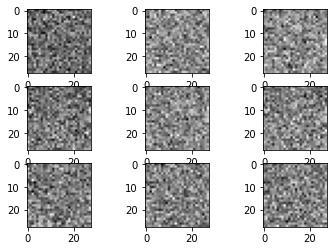

In [92]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    row = int(i/3)
    col = i % 3
    axs[row, col].imshow(example_reconstruction_hist[0][i, :, :], cmap="gray")

In [93]:
train_history = []; test_history = []
step_counter = 0
for epoch in range(EPOCHS):
    total_train_loss = 0
    for images in train_ds:
        train_loss = vae.train_step(images)
        total_train_loss += train_loss
        step_counter += 1
        tf.summary.experimental.set_step(step_counter)
        
    
    total_test_loss = 0
    for test_images in test_ds:
        test_loss = vae.test_step(test_images)
        total_test_loss += test_loss
    
    train_history.append(total_train_loss/len(train_ds))
    test_history.append(total_test_loss/len(test_ds))
    example_reconstruction_hist.append(vae(samples).numpy())
    
    print(f'Epoch {epoch + 1}, \n Loss: {total_train_loss.numpy()/len(train_ds)}, \n Test Loss: {total_test_loss.numpy()/len(test_ds)}')

Epoch 1, 
 Loss: 167.7677001953125, 
 Test Loss: 13.285408973693848
Epoch 2, 
 Loss: 76.02011108398438, 
 Test Loss: 12.446986198425293
Epoch 3, 
 Loss: 72.25377655029297, 
 Test Loss: 12.364508628845215
Epoch 4, 
 Loss: 70.89248657226562, 
 Test Loss: 11.675935745239258
Epoch 5, 
 Loss: 70.12138366699219, 
 Test Loss: 11.76618766784668
Epoch 6, 
 Loss: 69.39896392822266, 
 Test Loss: 11.72217082977295
Epoch 7, 
 Loss: 68.80603790283203, 
 Test Loss: 11.68118667602539
Epoch 8, 
 Loss: 68.27306365966797, 
 Test Loss: 11.814862251281738
Epoch 9, 
 Loss: 67.85962677001953, 
 Test Loss: 11.398144721984863
Epoch 10, 
 Loss: 67.19187927246094, 
 Test Loss: 11.524590492248535


In [95]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11744), started 0:02:32 ago. (Use '!kill 11744' to kill it.)

In [32]:
vae_reconstruction_test = vae(minitest)
vae.losses, loss_objective(minitest, vae_reconstruction_test)

([<tf.Tensor: shape=(), dtype=float32, numpy=0.023134002>],
 <tf.Tensor: shape=(), dtype=float32, numpy=0.24914117>)

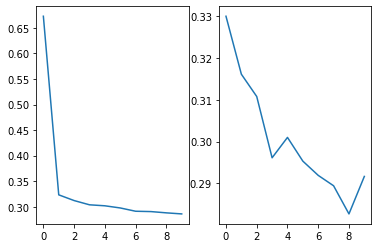

In [33]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_history)
axs[1].plot(test_history)

In [34]:
n = 1

In [35]:
[(a[0], b[0]) for a,b in zip(example_reconstruction_hist[n][0, 0, 0:10, :], example_reconstruction_hist[-1][1, 0, 0:10, :])]

[(0.00062450767, 9.929543e-05),
 (0.00024324656, 6.6502194e-05),
 (0.0003877282, 6.276804e-05),
 (0.00056400895, 7.50998e-05),
 (0.0005695522, 5.1486822e-05),
 (0.00036120415, 5.6570247e-05),
 (0.00029930472, 4.678808e-05),
 (0.00023716688, 6.2489475e-05),
 (0.0003017485, 6.497196e-05),
 (0.00032761693, 4.9882758e-05)]

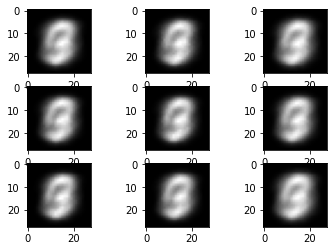

In [36]:
n = -1
fig, axs = plt.subplots(3,3)
for i in range(9):
    row = int(i/3)
    col = i % 3
    axs[row, col].imshow(example_reconstruction_hist[n][i, :, :], cmap="gray")

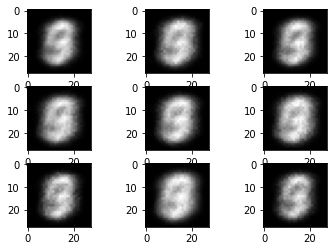

In [37]:
n = 1
fig, axs = plt.subplots(3,3)
for i in range(9):
    row = int(i/3)
    col = i % 3
    axs[row, col].imshow(example_reconstruction_hist[n][i, :, :], cmap="gray")

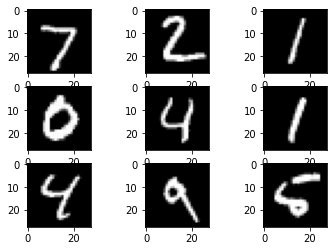

In [38]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    row = int(i/3)
    col = i % 3
    axs[row, col].imshow(samples[i, :, :], cmap="gray")

# Old/Other

In [ ]:
vae.fit(x_train,
        epochs=15,
        validation_data=(x_test, x_test))